[GSE181710](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE181710)

In [26]:
suppressPackageStartupMessages({
    library(Seurat)
    library(celldex)
    library(ShinyCell)
    library(dplyr)
    library(SingleR)
    library(data.table)
})

In [18]:
# Load sequencing data into R
options(timeout = 2000)
base_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE181nnn/GSE181710/suppl/"

metadata <- fread(paste0(base_url, "GSE181710%5Flibrary%5Fpatients%5Fsex.txt.gz"))

annotation_ctrl <- fread(paste0(base_url, "GSE181710%5Fsc%5Fcd4resting%5Fannotation.txt.gz"))
    
umi_ctrl <- fread(paste0(base_url, "GSE181710%5Fsc%5Fcd4resting%5Fumi.txt.gz"))

annotation_stim <- fread(paste0(base_url, "GSE181710%5Fsc%5Fcd4stim%5Fannotation.txt.gz"))
    
umi_stim  <- fread(paste0(base_url, "GSE181710%5Fsc%5Fcd4stim%5Fumi.txt.gz"))

In [ ]:
library(Matrix)

In [20]:
# Control
counts <- umi_ctrl
counts_mat <- Matrix(as.matrix(counts[,-1]), sparse = TRUE)
rownames(counts_mat) <- counts$gene_name
obj1 <- CreateSeuratObject(counts = counts_mat, meta.data = annotation_ctrl)
obj1

In [ ]:
# Stim
counts <- umi_stim
counts_mat <- Matrix(as.matrix(counts[,-1]), sparse = TRUE)
rownames(counts_mat) <- counts$gene_name
obj2 <- CreateSeuratObject(counts = counts_mat, meta.data = annotation_stim)
obj2

In [ ]:
obj <- merge(x = obj1, y = obj2)
obj <- SCTransform(obj, verbose = TRUE)

In [ ]:
# # Integration
# options(future.globals.maxSize = 8000 * 1024^2)
# obj1 <- SCTransform(obj1, verbose = TRUE)
# obj2 <- SCTransform(obj2, verbose = TRUE)
# seurat_list <- list(obj1, obj2)

# anchors <- FindIntegrationAnchors(object.list = seurat_list, anchor.features = VariableFeatures(obj1), verbose = TRUE)

# integrated_seurat <- IntegrateData(anchorset = anchors, verbose = TRUE)

In [ ]:
# Normalize and visualize

# obj <- SCTransform(integrated_seurat, verbose = TRUE)

# obj <- JoinLayers(obj)
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, dims = 1:30, verbose = TRUE)
obj <- FindNeighbors(obj, dims = 1:30, verbose = TRUE)
obj <- FindClusters(obj, resolution = 0.5, verbose = TRUE)
save(obj, file = "objects/00.rda")

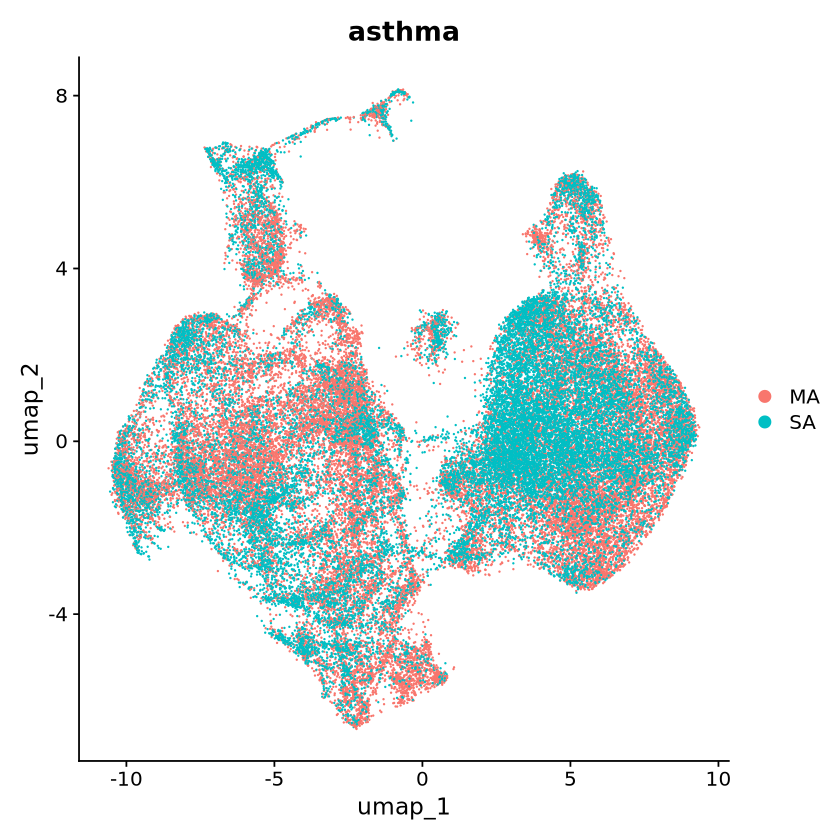

In [24]:
load(file = "objects/00.rda")
DimPlot(obj, group.by = "asthma")

In [ ]:
# Load annotation
monaco.ref <- celldex::MonacoImmuneData()
blueprint.ref <- celldex::BlueprintEncodeData()

In [33]:
load(file = "objects/01.rda")

In [34]:
# # Blueprint annnotation
# sce <- LayerData(obj)
# blueprint.main <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.main)
# obj@meta.data$blueprint.main <- blueprint.main$pruned.labels

obj <- SetIdent(obj, value = "blueprint.main")
obj <- subset(obj, idents = c("Erythrocytes", "NK cells", "DC", "Monocytes", "DC", "HSC"), invert = TRUE)

# Monaco annotation
# sce <- LayerData(obj)
# monaco.fine <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.fine)
# obj@meta.data$monaco.fine <- monaco.fine$pruned.labels
save(obj, file=file.path('objects', '01.rda'))


In [36]:
save(obj, file=file.path('objects', '01.rda'))

In [4]:
table(obj@meta.data$blueprint.main)


CD4+ T-cells CD8+ T-cells 
       14834        39516 

In [ ]:
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, dims = 1:30, verbose = TRUE)
obj <- FindNeighbors(obj, dims = 1:30, verbose = TRUE)
obj <- FindClusters(obj, resolution = 0.5, verbose = TRUE)

In [24]:
# Update metadata
load(file=file.path('objects', '01.rda'))
obj@meta.data$CellType_Specific <- obj@meta.data$celltype_subset
obj@meta.data$CellType_General <- obj@meta.data$celltype
obj@meta.data$Donor <- obj@meta.data$Donor_ID
obj@meta.data$Disease <- obj@meta.data$asthma
obj@meta.data$Stim <- obj@meta.data$stim
obj@meta.data$Batch <- obj@meta.data$batch

obj@meta.data$Disease <- gsub("MA", "Mild Asthma", obj@meta.data$Disease)
obj@meta.data$Disease <- gsub("SA", "Severe Asthma", obj@meta.data$Disease)

obj@meta.data$Stim <- gsub("US", "Control", obj@meta.data$Stim)
obj@meta.data$Stim <- gsub("ST", "PMA/Iono", obj@meta.data$Stim)

columns_to_keep <-  c('orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Batch', 'Donor', 'Sex', 'CellType_Specific', 'CellType_General', 'Stim', 'Disease', 'blueprint.main', 'monaco.fine')
obj@meta.data <- obj@meta.data[, columns_to_keep, drop = FALSE]
save(obj, file=file.path('objects', '02.rda'))

In [ ]:
load(file=file.path('objects', '02.rda'))
seu =  obj
scConf = createConfig(seu)
makeShinyApp(seu, scConf,
             gene.mapping = TRUE,
             shiny.title = "Asthma T-cells BAL scRNAseq (GSE181710)",
             shiny.dir = "asthma_scRNAseq_GSE181710/",
             gex.assay = "SCT",
             default.multigene = c('LILRB1', 'PDCD1')) 
system("R -e \"shiny::runApp('asthma_scRNAseq_GSE181710')\"")

Warning message in makeShinyFiles(obj = obj, scConf = scConf, gex.assay = gex.assay[1], :
“default.multigene doesn't exist in gene expression, using defaults...”
